In [3]:
import polars as pl
import matplotlib.pyplot as plt
import sys
import ase
import numpy as np
import scipy.optimize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
from enum import Enum
from ase.units import Hartree, kcal, mol
from dftmp2bench.pareto import is_pareto_efficient
from scipy.stats import linregress




In [4]:

FONTSIZE = 15

HF_color = "maroon"
GGA_color = "lightred"
mGGA_color = "orange"
HDFT_color = "chartreuse"
DHDFT_color = "forestgreen"
MP_color = "wheat"
CC_color = "gold"

###

HF=  "HF" 
GGA=  "GGA" 
mGGA=  "mGGA" 
HDFT=  "HDFT" 
DHDFT=  "DHDFT"
MP=  "MP" 
CC=  "CC" 

####

HF_marker = "o"
GGA_marker = "t"
mGGA_marker = "s"
HDFT_marker = "p"
DHDFT_marker = "h"
MP_marker = "P"
CC_marker = "*"

####

main_pareto_front_color = "black"
main_pareto_line_style = "--"

####

style_dict = {
    'wb97xd3': (HDFT_marker, HDFT_color),
    'camb3lyp': (HDFT_marker, HDFT_color),
    'dlpnoccsdt': (CC_marker, CC_color),
    'r2scan-3c': (mGGA_marker,mGGA_color),
    'wb97xd3bj': (HDFT_marker, HDFT_color),
    'pbe0': (HDFT_marker, HDFT_color),
    'hf': (HF_marker, HF_color),
    'PBEh-3c': (HDFT_marker, HDFT_color),
    'b2plyp': (DHDFT_marker, DHDFT_color), 
    'rimp2': (MP_marker, MP_color),
    'm062x': (HDFT_marker, HDFT_color),
    'wb97xv': (HDFT_marker, HDFT_color),
    'b973c': (HDFT_marker, HDFT_color),
    'ccsd': (CC_marker, CC_color),
    'mp2': (MP_marker, MP_color),
}

####

lot_type_dict = {
    'wb97xd3': HDFT,
    'camb3lyp': HDFT,
    'dlpnoccsdt': CC,
    'r2scan-3c': mGGA,
    'wb97xd3bj': HDFT,
    'pbe0': HDFT,
    'hf': HF,
    'PBEh-3c': HDFT,
    'b2plyp': DHDFT,
    'rimp2': MP,
    'm062x': HDFT,
    'wb97xv': HDFT,
       'b973c': HDFT,
    'ccsd': CC,
    'mp2': MP,
}
###
theory_type_style_dict = {
    'mGGA': (mGGA_marker,mGGA_color),
    'HF': (HF_marker, HF_color),
    'DHDFT': (DHDFT_marker, DHDFT_color), 
    'HDFT': (HDFT_marker, HDFT_color),
    'CC': (CC_marker, CC_color),
    'MP': (MP_marker, MP_color),
}



In [21]:
class Software(Enum):
    ORCA = "orca"
    GAUSSIAN = "gaussian"

class Dfcols(Enum):
    MOLECNAME = "molecule_name"
    WALLTIME = "wall_time"
    LOT = "level_of_theory"
    BASIS = "basis"
    SOFTWARE = "software"
    ENERGY = "energy"
    THEORYTYPE = "theory_type"
    RELWALLTIME = "wall_time" #"relative_walltime"
    ABSERRORKCAL = "absolute_error_kcalmol"
    NBASIS = "nbasis"
    


In [22]:
project_path = Path("/cluster/home/schmidtn/master/wahlprak/dftmp2bench")
#csv_path = project_path/"csvs"/"summary-rerun-2025-01-30-0e55d9c8-def7-11ef-8425-5379090b8daf.csv" #tag = rerun
#csv_path = project_path / "csvs" / "OutputSummary-2025-01-27.csv" #tag = benchmark
#csv_path = project_path / "csvs" / "summary-charge_test-2025-01-31-3b956976-dfd8-11ef-8425-5379090b8daf.csv" #tag = charge_test
#csv_path = project_path / "csvs" / "summary-charge_test2-2025-02-03-5d0bcbee-e213-11ef-8425-5379090b8daf.csv" #tag = charge_test2
csv_path = project_path / "csvs" / "summary-charge_test2-2025-02-04-105a6652-e2ea-11ef-8425-5379090b8daf.csv" #tag = charge_test2


index: 0
MolecName: AKA_cation_singlet.xyz
LOT/Basis, Program on pareto front:
hf/sto3g, gaussian
mp2/sto3g, gaussian
mp2/sto3g, orca
pbe0/sto3g, orca
m062x/sto3g, orca
b973c/631+gd, orca
pbe0/def2svp, orca
PBEh-3c/6311++g2d2p, orca
rimp2/ccpvdz, orca

index: 1
MolecName: AKA_W5_cation_singlet.xyz
LOT/Basis, Program on pareto front:
hf/sto3g, gaussian
hf/sto3g, orca
mp2/sto3g, gaussian
pbe0/sto3g, orca
m062x/sto3g, orca
b973c/def2tzvpp, orca
pbe0/def2svp, orca
PBEh-3c/sto3g, orca
PBEh-3c/6311++g2d2p, orca
rimp2/ccpvdz, orca
b2plyp/def2svp, gaussian

index: 2
MolecName: ALA_neutral_singlet.xyz
LOT/Basis, Program on pareto front:
hf/sto3g, gaussian
mp2/sto3g, gaussian
mp2/sto3g, orca
m062x/sto3g, orca
b973c/def2svp, orca
b973c/def2tzvpp, orca
pbe0/def2svp, orca
PBEh-3c/def2svp, orca
PBEh-3c/def2svpd, orca
rimp2/ccpvdz, orca


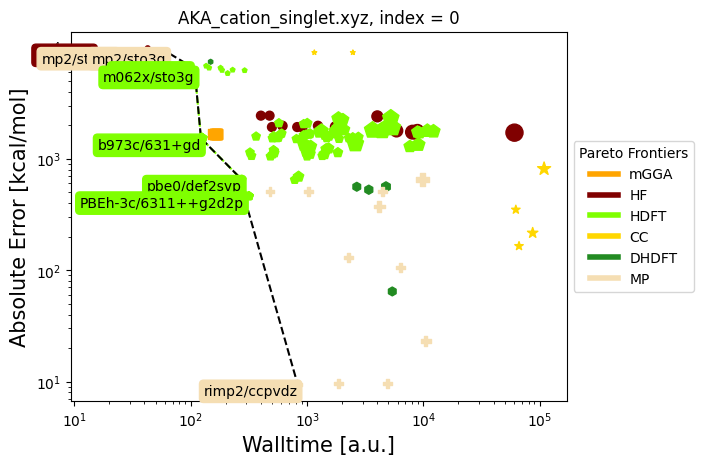

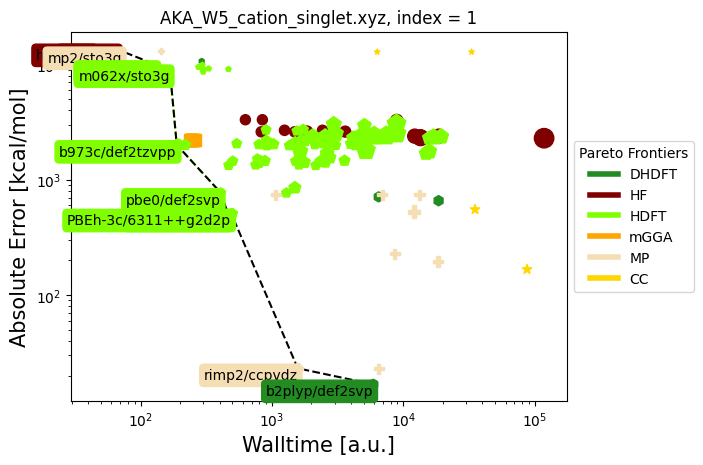

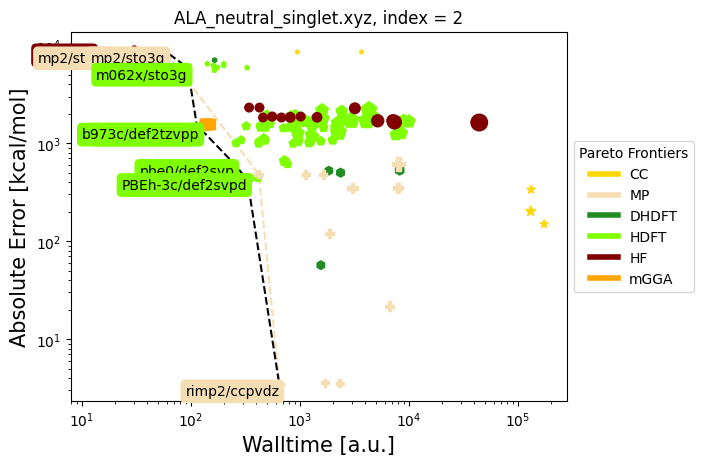

In [25]:
# need to loop over all cells (REF value, abserror, relwalltime calcualtion etc. --> put everything in one cell)

#REF_SOFTWARE = Software.ORCA.value
#REF_LOT = "b2plyp" 
#REF_BASIS = "631+gd" #"ccpvdz" 

REF_LOT = "mp2"  
REF_BASIS = "631+gdp" #"def2svpd" #"6311++g2d2p"  

nproc = 8 #defines number of proccessors used 

q = (pl.scan_csv(csv_path))
df = q.collect()



"""
split the df into multiple dfs by molecule name  
"""
#dfs = pl.dataframe
dfsplit = df.partition_by([Dfcols.MOLECNAME.value])



"""
loops over the dataframes of all molecules
"""

for index in range(0, len(dfsplit)):
    
    """
    defines MolecName
    """
    
    MolecNameDf = (dfsplit[index][Dfcols.MOLECNAME.value])
    MolecName = MolecNameDf.item(0)

    print("")
    print(f"index: {index}")##########################################################################################################################################
    print(f"MolecName: {MolecName}")###################################################################################################################################
    
    """
    calculates REFs for each df 
    """
    REF_ENERGY = dfsplit[index].filter( 
        (pl.col(Dfcols.LOT.value) == REF_LOT) & (pl.col(Dfcols.BASIS.value) == REF_BASIS) #& (pl.col(Dfcols.SOFTWARE.value) == REF_SOFTWARE) 
    )[Dfcols.ENERGY.value][0]
    #print(f"REF ENERGY of {MolecName} = {REF_ENERGY}")#################################################################################################################
    
    REF_WALLTIME = dfsplit[index].filter(
        (pl.col(Dfcols.LOT.value) == REF_LOT) & (pl.col(Dfcols.BASIS.value) == REF_BASIS) #& (pl.col(Dfcols.SOFTWARE.value) == REF_SOFTWARE)
    )[Dfcols.WALLTIME.value][0]
    #print(f"REF WALLTIME of {MolecName} = {REF_WALLTIME}")#############################################################################################################

    """
    Sorts the dataframes and adds columns for absolute error, signed error and relative walltime 
    """
    
    dfsplit[index] = dfsplit[index].sort([Dfcols.MOLECNAME.value, Dfcols.SOFTWARE.value, Dfcols.LOT.value, Dfcols.BASIS.value])

    dfsplit[index] = dfsplit[index].with_columns(
        absolute_error_kcalmol = abs(pl.col(Dfcols.ENERGY.value) - REF_ENERGY) / (kcal/mol),
        signed_error_kcalmol = (pl.col(Dfcols.ENERGY.value) - REF_ENERGY) / (kcal/mol),
        relative_walltime = pl.col(Dfcols.WALLTIME.value) / REF_WALLTIME
    )

    #print(dfsplit[index])##############################################################################################################################################

    """
    adds theory type to the df
    """
    
    list_of_theory_types = []
    for i in dfsplit[index][Dfcols.LOT.value]:
        list_of_theory_types.append(lot_type_dict[i])
    s = pl.Series(Dfcols.THEORYTYPE.value, list_of_theory_types)
    
    x = dfsplit[index].get_column_index(Dfcols.LOT.value) 
    dfsplit[index].insert_column(x+1,s)


    """
    plots figure
    """

    plt.figure(index)
    ax = plt.gca()
    
    for v in dfsplit[index][Dfcols.THEORYTYPE.value].unique():
        _dfsplit = dfsplit[index].filter(
                ~(pl.col(Dfcols.BASIS.value) == REF_BASIS) & (pl.col(Dfcols.LOT.value) == REF_LOT) #& (pl.col("software") != REF_SOFTWARE)
            )
        
        _dfsplit = dfsplit[index].filter((pl.col(Dfcols.THEORYTYPE.value) == v)) 
        
        """
        plots rel_walltime vs absolute error of each theory_type in the same color and same symbol
        """

        plt.scatter(_dfsplit[Dfcols.RELWALLTIME.value], _dfsplit[Dfcols.ABSERRORKCAL.value],
                    s = (_dfsplit[Dfcols.NBASIS.value])/10,
                    c = theory_type_style_dict[v][1],
                    marker = theory_type_style_dict[v][0]
                    )
    

    #print(_dfsplit)####################################################################################################
    
    """
    checks if an entry in _dfsplit is on the pareto front, if it is: adds entry to _pfsplit 
    """
    
    _pfsplit = _dfsplit.filter(
        is_pareto_efficient(
            _dfsplit[[Dfcols.ABSERRORKCAL.value, Dfcols.RELWALLTIME.value]].to_numpy())
        ).sort([Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value])
    #print(f"index: {index}")####################################################################################################


    
    """
    plots _pfsplit
    """
    
    plt.plot(_pfsplit[Dfcols.RELWALLTIME.value],
            _pfsplit[Dfcols.ABSERRORKCAL.value],
             zorder = -1,
             linestyle = main_pareto_line_style,
             c = theory_type_style_dict[v][1],
            )

    
    """
    filters the reference basis from the df, so it is not considered in the plot of the pf
    """

    values_to_compare = dfsplit[index].filter(
                (pl.col(Dfcols.BASIS.value) != REF_BASIS) | (pl.col(Dfcols.LOT.value) != REF_LOT) #& (pl.col("software") != REF_SOFTWARE)
            )
    #print(f"Basis: {pl.col(Dfcols.BASIS.value)}, REF Basis: {REF_BASIS}, LOT: {pl.col(Dfcols.LOT.value)}, REF LOT: {REF_LOT}")############################################

    """
    puts pareto efficient entries from values_to_compare into a new list df, values_to_compare_pfsplit
    """
    
    values_to_compare_pfsplit = values_to_compare.filter(
        is_pareto_efficient(
           values_to_compare[[Dfcols.ABSERRORKCAL.value, Dfcols.RELWALLTIME.value]].to_numpy())     
        ).sort([Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value]) 

    
    """
    plots values_to_compare_pfsplit
    """

    plt.plot(values_to_compare_pfsplit[Dfcols.RELWALLTIME.value],
            values_to_compare_pfsplit[Dfcols.ABSERRORKCAL.value],
            zorder = -1,
            linestyle = main_pareto_line_style,
            c = main_pareto_front_color,
            )

    """
    ???
    """
    
    min_USEkcalmol = min(values_to_compare_pfsplit[Dfcols.ABSERRORKCAL.value])
    
    min_USEkcalmol_rel_walltime = values_to_compare_pfsplit.filter(pl.col(Dfcols.ABSERRORKCAL.value) == min_USEkcalmol)[Dfcols.RELWALLTIME.value][0]

    
    
    """
    Labels Method and basis set and shifts the labels for certain theory types
    """
    
    print("LOT/Basis, Program on pareto front:")#################################################################################################################################
    zipped_vals = zip(*values_to_compare_pfsplit[[Dfcols.THEORYTYPE.value, Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value, Dfcols.BASIS.value, Dfcols.LOT.value, Dfcols.SOFTWARE.value]])
    for theory, x, y, basis, level_of_theory, software in zipped_vals:
        shift_ = 0
        print(f"{level_of_theory}/{basis}, {software}")#################################################################################################################
        # if theory == "HF":
        #     shift_ = 0.1   
        ax.text(x + shift_/100, y + shift_*10**4, f"{level_of_theory}/{basis}", 
                horizontalalignment='right',
                verticalalignment='top',
                bbox=dict(boxstyle="round",
                       ec=theory_type_style_dict[theory][1],
                       fc=theory_type_style_dict[theory][1],
                         )
               )
    
    """
    Config data for axes and their labels, legend and saving of png file.
    """
    
    ax.set_title(f"{MolecName}, index = {index}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    #ax.set_ylim(7000, 13000)
    #ax.set_xlabel(f"Relative Walltime [a.u.] (nproc = {nproc})", fontsize = FONTSIZE)
    ax.set_xlabel(f"Relative Walltime [a.u.]", fontsize = FONTSIZE)
    ax.set_ylabel(f"Absolute Error [kcal/mol]" , fontsize = FONTSIZE)
    #if MolecName == "AKA_W5_cation_singlet.xyz":
        #ax.set_ylim(10000, 18000)
    if Dfcols.RELWALLTIME == Dfcols.WALLTIME:
        ax.set_xlabel(f"Walltime [a.u.]", fontsize = FONTSIZE)
        
 
    legend_elements = [Line2D([0], [0], color=theory_type_style_dict[v][1], lw=4, label=v) for v in dfsplit[index][Dfcols.THEORYTYPE.value].unique()]
    ax.legend(handles=legend_elements, title="Pareto Frontiers", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"test_{MolecName}.pdf", bbox_inches="tight")



In [10]:
df.filter(
    (pl.col("level_of_theory") == "mp2") & (pl.col("basis") == "631+gdp")
).sort("nbasis")


name,molecule_name,software,wall_time,basis,level_of_theory,energy,nbasis,termination
str,str,str,f64,str,str,f64,i64,str
"""/cluster/home/schmidtn/master/…","""ALA_neutral_singlet.xyz""","""orca""",3360.284,"""631+gdp""","""mp2""",-25403.788787,457,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""ALA_neutral_singlet.xyz""","""gaussian""",6657.2,"""631+gdp""","""mp2""",-25404.72798,476,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""orca""",4776.264,"""631+gdp""","""mp2""",-26918.199554,485,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""gaussian""",10469.6,"""631+gdp""","""mp2""",-26919.204524,505,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_W5_cation_singlet.xyz""","""gaussian""",12375.3,"""631+gdp""","""mp2""",-37294.658244,650,"""NORMAL TERMINATION"""


In [30]:
df.filter(
    pl.col("level_of_theory") == "dlpnoccsdt"
).sort(by="nbasis")#.group_by("basis").count()

name,molecule_name,software,wall_time,basis,level_of_theory,energy,nbasis,termination
str,str,str,f64,str,str,f64,i64,str
"""/cluster/home/schmidtn/master/…","""ALA_neutral_singlet.xyz""","""orca""",132511.055,"""def2svp""","""dlpnoccsdt""",-25389.183275,381,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""ALA_neutral_singlet.xyz""","""orca""",174283.838,"""ccpvdz""","""dlpnoccsdt""",-25410.28068,381,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""orca""",62245.619,"""def2svp""","""dlpnoccsdt""",-26903.05193,405,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""orca""",66278.795,"""ccpvdz""","""dlpnoccsdt""",-26925.34063,405,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_W5_cation_singlet.xyz""","""orca""",35178.674,"""def2svp""","""dlpnoccsdt""",-37270.693389,525,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_W5_cation_singlet.xyz""","""orca""",87497.863,"""ccpvdz""","""dlpnoccsdt""",-37301.889477,525,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""ALA_neutral_singlet.xyz""","""orca""",131243.989,"""def2svpd""","""dlpnoccsdt""",-25395.008742,576,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""orca""",86849.571,"""def2svpd""","""dlpnoccsdt""",-26908.839308,612,"""NORMAL TERMINATION"""
"""/cluster/home/schmidtn/master/…","""AKA_cation_singlet.xyz""","""orca""",108857.317,"""def2tzvpp""","""dlpnoccsdt""",-26953.394671,970,"""NORMAL TERMINATION"""


In [415]:
df.filter(
    (pl.col("level_of_theory") == "pbe0") & (pl.col("basis") == "def2svp")
).sort("nbasis")["wall_time"] 

wall_time
f64
250.498
771.1
274.845
782.7
408.277
1289.4


Text(0, 0.5, 'Log Walltime [s] (nproc = 8)')

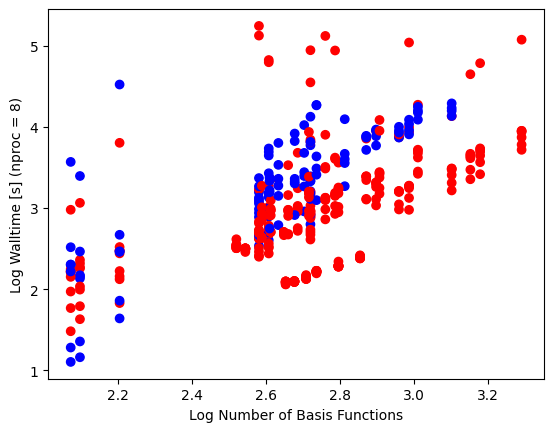

In [380]:
#####################################################################################################################################################
#Under Construction
#####################################################################################################################################################



"""
plots nbasis vs walltime for different methods/basis sets in gaussian (blue) and orca (red)
"""

plt.scatter(np.log10(df[Dfcols.NBASIS.value]), np.log10(df[Dfcols.WALLTIME.value]), c = ["r" if softw == Software.ORCA.value else "b" for softw in df[Dfcols.SOFTWARE.value]])

#plt.scatter((df[Dfcols.NBASIS.value]), np.log(df[Dfcols.WALLTIME.value]), c = ["r" if softw == Software.ORCA.value else "b" for softw in df[Dfcols.SOFTWARE.value]])
#plt.xscale("log")
#plt.yscale("log")

plt.xlabel("Log Number of Basis Functions")
plt.ylabel(f"Log Walltime [s] (nproc = {nproc})")

In [244]:
TYPE = "HDFT"

"""
plots nbasis vs walltime for a specific theory type in gaussian (blue)
"""


_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == Software.GAUSSIAN.value)
)

slope, intercept, r, p, se = linregress(np.log(_[Dfcols.NBASIS.value]), np.log(_[Dfcols.WALLTIME.value]))
print(f"slope: {slope}, intercept: {intercept}")

plt.scatter(np.log10(_[Dfcols.NBASIS.value]), np.log10(_[Dfcols.WALLTIME.value]), c = ["r" if x == Software.ORCA.value else "b" for x in _[Dfcols.SOFTWARE.value]]) 

plt.xlabel("Log Number of Basis Functions")
plt.ylabel("Log Walltime [s]")
plt.ylim(0, 5)

    



"""
plots nbasis vs walltime for a specific theory type in orca (red)
"""

_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == Software.ORCA.value)
)

slope, intercept, r, p, se = linregress(np.log(_[Dfcols.NBASIS.value]), np.log(_[Dfcols.WALLTIME.value]))
print(f"slope: {slope}, intercept: {intercept}")

plt.scatter(np.log10(_[Dfcols.NBASIS.value]), np.log10(_[Dfcols.WALLTIME.value]), c = ["r" if x == Software.ORCA.value else "b" for x in _[Dfcols.SOFTWARE.value]]) 

plt.xlabel("Log Number of Basis Functions")
plt.ylabel(f"Log Walltime [s] (nproc = {nproc})")
plt.ylim(0, 5)

ColumnNotFoundError: unable to find column "theory_type"; valid columns: ["name", "software", "wall_time", "basis", "level_of_theory", "energy", "nbasis", "termination"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'filter' <---
DF ["name", "software", "wall_time", "basis"]; PROJECT */8 COLUMNS

In [52]:
np.arange(0, 355.0, 6) + 1

array([  1.,   7.,  13.,  19.,  25.,  31.,  37.,  43.,  49.,  55.,  61.,
        67.,  73.,  79.,  85.,  91.,  97., 103., 109., 115., 121., 127.,
       133., 139., 145., 151., 157., 163., 169., 175., 181., 187., 193.,
       199., 205., 211., 217., 223., 229., 235., 241., 247., 253., 259.,
       265., 271., 277., 283., 289., 295., 301., 307., 313., 319., 325.,
       331., 337., 343., 349., 355.])

In [55]:
np.array([ 0, 6, 12]) + 1

array([ 1,  7, 13])

In [61]:
#  dihedral: 32,18,15,13, 165.0; 165.0, 524.0, 60 
#  dihedral: 18,15,13,8, -162.0; -162.0, 384.0, 60

dih1, dih2 = (np.arange(0, 355.0, 6) + 165), (np.arange(0, 355.0, 6) - 162)

In [69]:
import itertools
from itertools import product as cartesian_product

phi_psi_array = np.array(list(cartesian_product(dih1, dih2)))

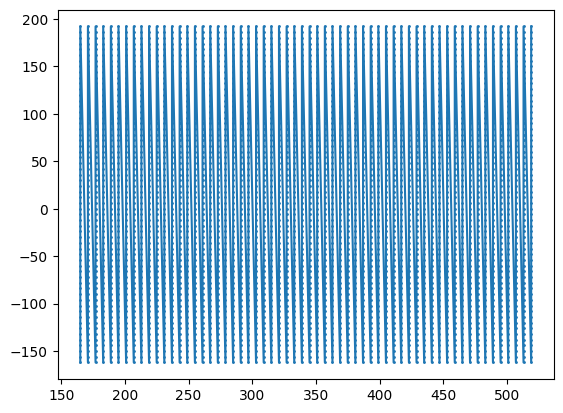

In [75]:
plt.scatter(*phi_psi_array.T, s=1)
plt.plot(*phi_psi_array.T)

In [245]:
"""
calculate and optimize exponential weight function using Nelder-Mead
"""

REFSOFTWARE = Software.ORCA.value #((for which software should the regression line be plotted?))
#REFSOFTWARE = Software.GAUSSIAN.value

_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == REFSOFTWARE)
)


def scaling(nbasis, x, a, c):
    return a * nbasis**x + c

def cost_function(args):
    nbasis = _[Dfcols.NBASIS.value]
    expected_walltime = _[Dfcols.WALLTIME.value]*nproc #*nproc so walltime is scaled for 1 proccessor 
    pred_walltime = [scaling(nb, *args) for nb in nbasis]
    cost = np.mean([(a - b)**2 for a, b in zip(expected_walltime, pred_walltime)])
    return cost

x0 = [1, 1, 0]
res = scipy.optimize.minimize(cost_function, x0, method='Nelder-Mead',
                    #bounds + [(2.5, 10), (0.1, 1), (-1000, 1000)]
                    )

res
    

ColumnNotFoundError: unable to find column "theory_type"; valid columns: ["name", "software", "wall_time", "basis", "level_of_theory", "energy", "nbasis", "termination"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'filter' <---
DF ["name", "software", "wall_time", "basis"]; PROJECT */8 COLUMNS

Text(0, 0.5, 'Walltime (nproc = 1)')

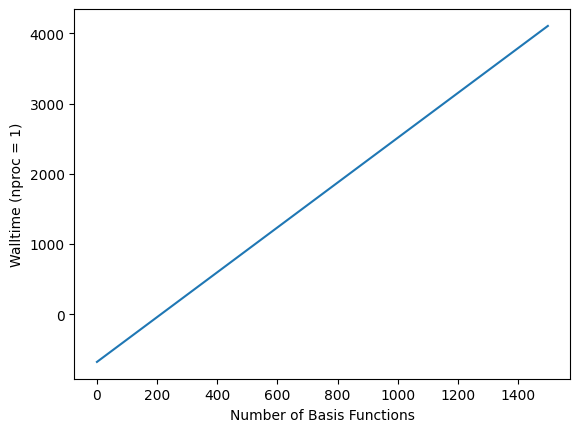

In [246]:
"""
plot regression line 
"""

plt.scatter(_[Dfcols.NBASIS.value], _[Dfcols.WALLTIME.value]*nproc, c = ["r" if software == Software.ORCA.value else "b" for software in _[Dfcols.SOFTWARE.value]])
xvalues = np.arange(0, 1500)
pred_walltimes = [scaling(nb, *res.x) for nb in xvalues]

plt.plot(xvalues, pred_walltimes)

plt.xlabel("Number of Basis Functions")
plt.ylabel("Walltime (nproc = 1)")

In [247]:
[*res.x]

[np.float64(3.192329412809495), np.float64(-678.3556386375963)]

In [248]:
"""
calculate and optimize linear weight function using Nelder-Mead 
"""
def scaling(nbasis, m, c):
    return m*nbasis + c 

def cost_function(args):
    nbasis = _[Dfcols.NBASIS.value]
    expected_walltime = _[Dfcols.WALLTIME.value]*nproc #*nproc so walltime is scaled for 1 proccessor 
    pred_walltime = [scaling(nb, *args) for nb in nbasis]
    cost = np.mean([(a - b)**2 for a, b in zip(expected_walltime, pred_walltime)])
    return cost

x0 = [1, 0]
res = scipy.optimize.minimize(cost_function, x0, method='Nelder-Mead',
                    #bounds + [(2.5, 10), (0.1, 1), (-1000, 1000)]
                    )

res
    

/cluster/home/schmidtn/master/wahlprak/dftmp2bench/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/home/schmidtn/master/wahlprak/dftmp2bench/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: nan
             x: [ 1.000e+00  0.000e+00]
           nit: 100
          nfev: 400
 final_simplex: (array([[ 1.000e+00,  0.000e+00],
                       [ 1.000e+00,  0.000e+00],
                       [ 1.000e+00,  3.944e-34]]), array([       nan,        nan,        nan]))

Text(0, 0.5, 'Walltime (nproc = 1)')

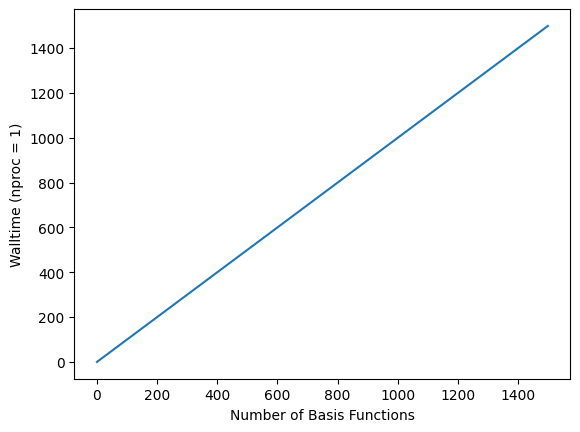

In [249]:
"""
plot regression line 
"""

plt.scatter(_[Dfcols.NBASIS.value], _[Dfcols.WALLTIME.value]*nproc, c = ["r" if software == Software.ORCA.value else "b" for software in _[Dfcols.SOFTWARE.value]])
xvalues = np.arange(0, 1500)
pred_walltimes = [scaling(nb, *res.x) for nb in xvalues]

plt.plot(xvalues, pred_walltimes)

plt.xlabel("Number of Basis Functions")
plt.ylabel("Walltime (nproc = 1)")

In [250]:
[*res.x]

[np.float64(1.0), np.float64(0.0)]